In [1]:
import numpy as np
import pandas as pd
import plotnine as p9

import polygraph.input, polygraph.embedding, polygraph.motifs, polygraph.models, polygraph.sequence, polygraph.utils, polygraph.visualize, polygraph.stats, polygraph.likelihood

pd.set_option('display.precision', 2)
%matplotlib inline

## Tutorial on human data

### Read in data

In [2]:
seqs = polygraph.input.read_seqs('human_seqs.txt', sep=",")
seqs.head(3)

,Sequence,Group
SeqID,,
seq_0,GCTCGTGAGCCGTCAAGGATGCGCTCACCATCGAGCCACACGTTGG...,FastSeqProp
seq_1,GTTCGCCCGCGCATGGAGCAACGCTCTCGTTAGGACGCTTTCGTCC...,FastSeqProp
seq_2,TTTGACAGTTCCCGCCAAAATCGGACCTAGCCGTCTCAAGGCCGAG...,FastSeqProp


In [3]:
print(seqs.Group.value_counts())

FastSeqProp            2000
Simulated_Annealing    2000
AdaLead                2000
native                 2000
random                 2000
Name: Group, dtype: int64


# 1. Evaluate sequence composition

## 1.1 GC Content

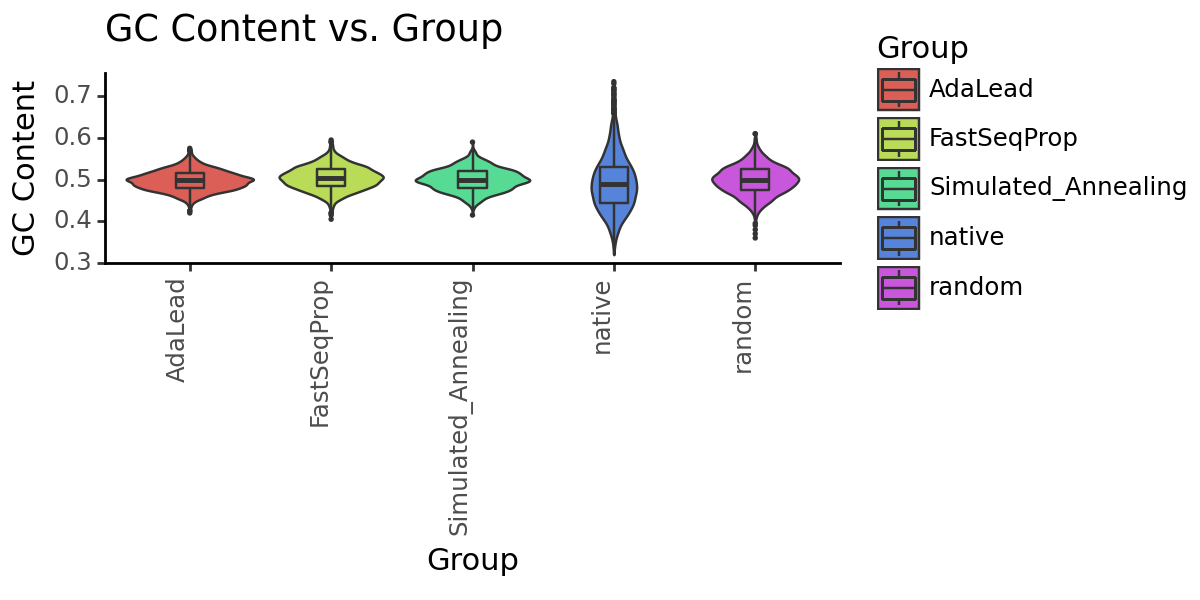

<Figure Size: (600 x 300)>

In [4]:
seqs['GC Content'] = polygraph.sequence.gc(seqs)
polygraph.visualize.boxplot(seqs, value_col='GC Content') + p9.theme(figure_size=(6, 3))

In [5]:
polygraph.stats.kruskal_dunn(data=seqs, val_col="GC Content")

{'Kruskal': 3.3631365849739994e-30,
 'Dunn':                       AdaLead  FastSeqProp  Simulated_Annealing    native  \
 AdaLead              1.00e+00     4.47e-11             1.06e-02  1.33e-06   
 FastSeqProp          4.47e-11     1.00e+00             5.14e-05  1.28e-30   
 Simulated_Annealing  1.06e-02     5.14e-05             1.00e+00  1.89e-13   
 native               1.33e-06     1.28e-30             1.89e-13  1.00e+00   
 random               1.64e-01     2.11e-07             2.36e-01  4.34e-10   
 
                        random  
 AdaLead              1.64e-01  
 FastSeqProp          2.11e-07  
 Simulated_Annealing  2.36e-01  
 native               4.34e-10  
 random               1.00e+00  }

## 1.2 Length distribution

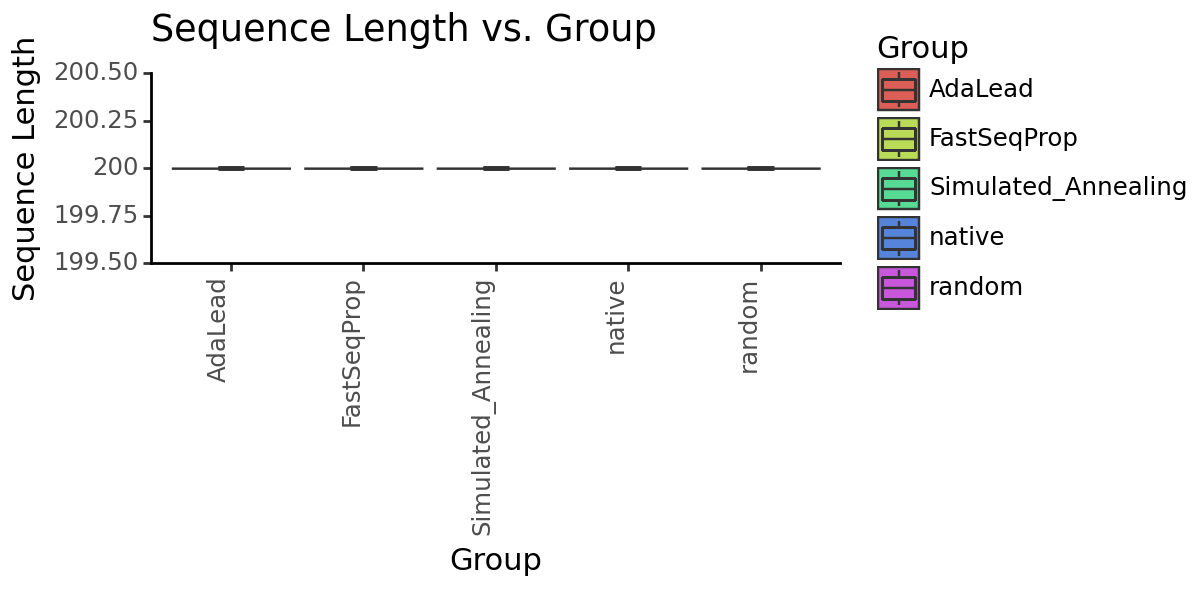

<Figure Size: (600 x 300)>

In [6]:
seqs['Sequence Length'] = seqs.Sequence.apply(len)
polygraph.visualize.boxplot(seqs, value_col='Sequence Length') + p9.theme(figure_size=(6, 3))

## 1.3 Edit distance

In [7]:
%%time
seqs['edit'] = polygraph.sequence.min_edit_distance_from_reference(seqs, reference_group='native')

CPU times: user 3min 9s, sys: 0 ns, total: 3min 9s
Wall time: 3min 9s


{'Kruskal': 1.9086677480032196e-133, 'Dunn':                        AdaLead  FastSeqProp  Simulated_Annealing     random
AdaLead               1.00e+00     2.42e-15             2.51e-11  8.87e-126
FastSeqProp           2.42e-15     1.00e+00             2.05e-01   4.67e-57
Simulated_Annealing   2.51e-11     2.05e-01             1.00e+00   4.69e-66
random               8.87e-126     4.67e-57             4.69e-66   1.00e+00}


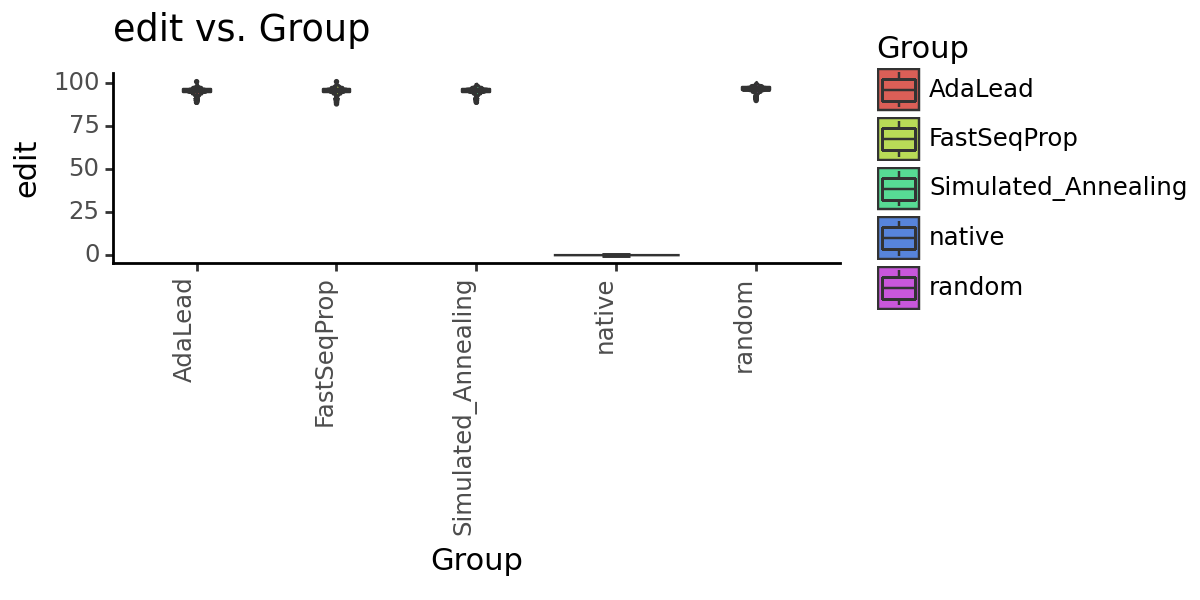

<Figure Size: (600 x 300)>

In [8]:
print(polygraph.stats.kruskal_dunn(seqs[seqs.Group!='native'], val_col='edit'))
polygraph.visualize.boxplot(seqs, value_col='edit') + p9.theme(figure_size=(6, 3))

## 1.4 k-mer content

In [9]:
%%time
kmers = polygraph.sequence.kmer_frequencies(seqs, k=5, normalize=True)
print(kmers.shape)
kmers.iloc[:5, :5]

(10000, 1024)
CPU times: user 15.5 s, sys: 437 ms, total: 16 s
Wall time: 16 s


,AAAAA,AAAAC,AAAAG,AAAAT,AAACA
seq_0,0.0,0.0,0.00e+00,0.00e+00,0.00
seq_1,0.0,0.0,5.10e-03,0.00e+00,0.00
seq_2,0.0,0.0,0.00e+00,5.10e-03,0.00
seq_3,0.0,0.0,0.00e+00,0.00e+00,0.00
seq_4,0.0,0.0,0.00e+00,0.00e+00,0.01


In [10]:
%%time
emb = polygraph.embedding.embedding_analysis(kmers, seqs, reference_group='native', use_pca=True)

Creating AnnData object
PCA
Fraction of total variance explained by PCA components:  0.24987976011050128
UMAP


2024-01-31 01:09:32.184634: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Differential feature abundance
1-NN statistics
Within-group KNN diversity
Euclidean distance to nearest reference
Train groupwise classifiers
CPU times: user 3min 12s, sys: 3min 35s, total: 6min 47s
Wall time: 44.4 s


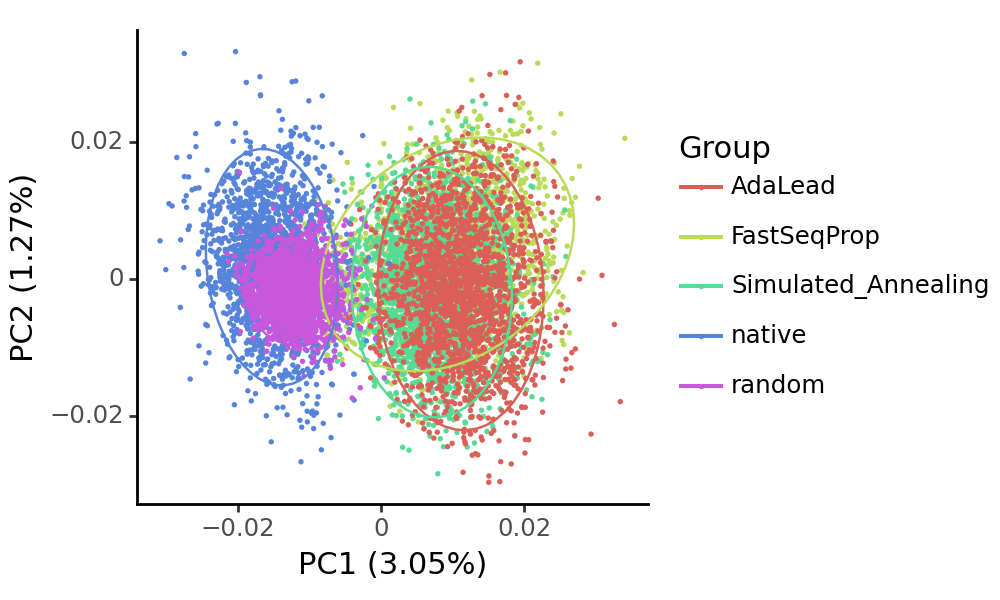

<Figure Size: (500 x 300)>

In [11]:
polygraph.visualize.pca_plot(emb, show_ellipse=True) + p9.theme(figure_size=(5, 3))

In [12]:
# Differential k-mer abundance

print("Number of differential k-mers compared to reference")
print(emb.uns["DE_test"][emb.uns["DE_test"].padj < .05].Group.value_counts())

print("")

print("Top Differential k-mers")
print(emb.uns["DE_test"][emb.uns["DE_test"].padj < .05].sort_values('padj').head())

Number of differential k-mers compared to reference
random                 765
FastSeqProp            722
Simulated_Annealing    717
AdaLead                713
Name: Group, dtype: int64

Top Differential k-mers
                    Group  value  score       padj  log2FC
1024          FastSeqProp  GATAA  38.48   0.00e+00    1.93
0                 AdaLead  TTATC  36.80  1.76e-293    1.91
1025          FastSeqProp  TTATC  34.04  3.17e-251    1.77
2048  Simulated_Annealing  TTATC  33.95  1.33e-249    1.76
1                 AdaLead  GATAA  33.64  2.60e-245    1.74


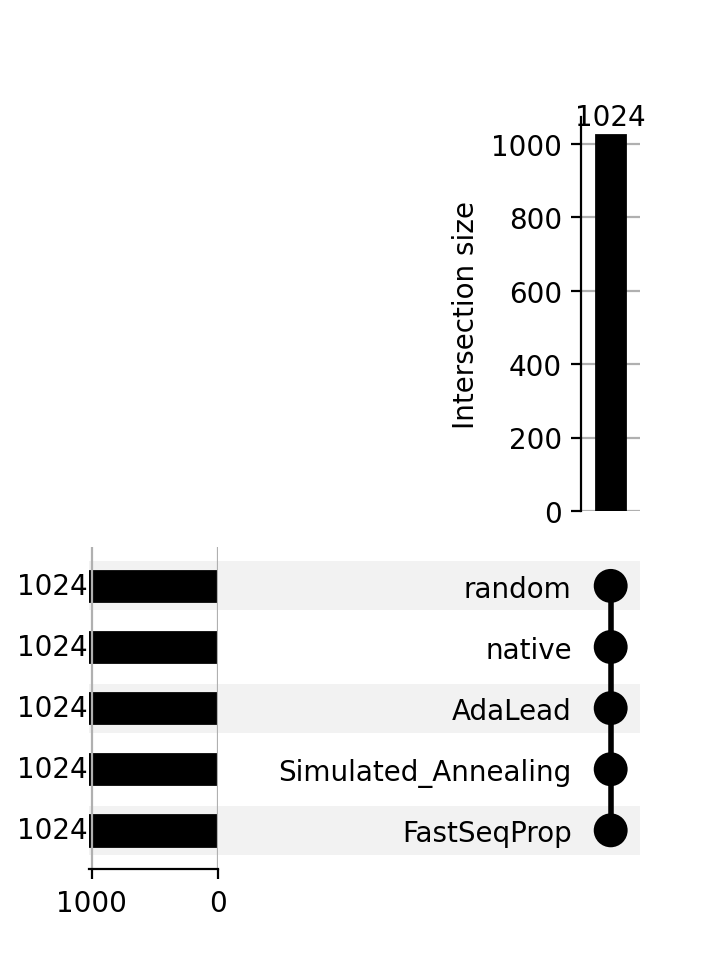

In [13]:
# kmer occurrence
polygraph.visualize.upset_plot(emb)

Fraction of sequences by 1-NN group
                     group_prop  ref_prop
Group                                    
FastSeqProp            1.95e-02      0.98
Simulated_Annealing    9.50e-03      1.00
AdaLead                4.00e-03      1.00
random                 1.20e-02      0.88

p-values for proportion of sequences with native nearest neighbor
                     group_prop  ref_prop  pval  padj
Group                                                
FastSeqProp            1.95e-02      0.98   0.0   0.0
Simulated_Annealing    9.50e-03      1.00   0.0   0.0
AdaLead                4.00e-03      1.00   0.0   0.0
random                 1.20e-02      0.88   0.0   0.0


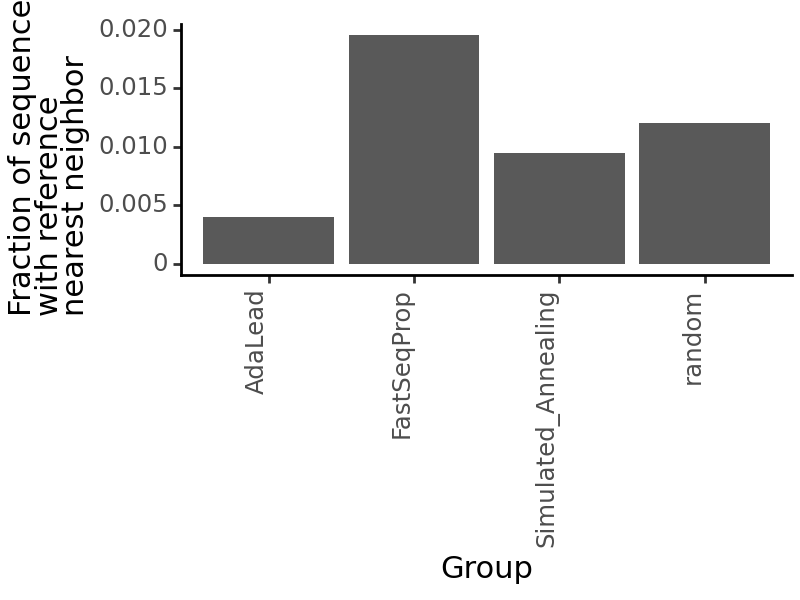

<Figure Size: (400 x 300)>

In [14]:
# 1-NN statistics
print("Fraction of sequences by 1-NN group")
print(emb.uns["1NN_group_probs"])

print("")

print("p-values for proportion of sequences with native nearest neighbor")
print(emb.uns["1NN_ref_prop_test"])

# Plot
polygraph.visualize.one_nn_frac_plot(emb, reference_group="native") + p9.theme(figure_size=(4,3))

p-values for distance to closest reference
{'Kruskal': 0.0, 'Dunn':                       AdaLead  FastSeqProp  Simulated_Annealing  native  \
AdaLead              1.00e+00     9.40e-35             1.76e-42    0.00   
FastSeqProp          9.40e-35     1.00e+00             1.89e-01    0.00   
Simulated_Annealing  1.76e-42     1.89e-01             1.00e+00    0.00   
native               0.00e+00     0.00e+00             0.00e+00    1.00   
random               0.00e+00     0.00e+00             0.00e+00    0.69   

                     random  
AdaLead                0.00  
FastSeqProp            0.00  
Simulated_Annealing    0.00  
native                 0.69  
random                 1.00  }


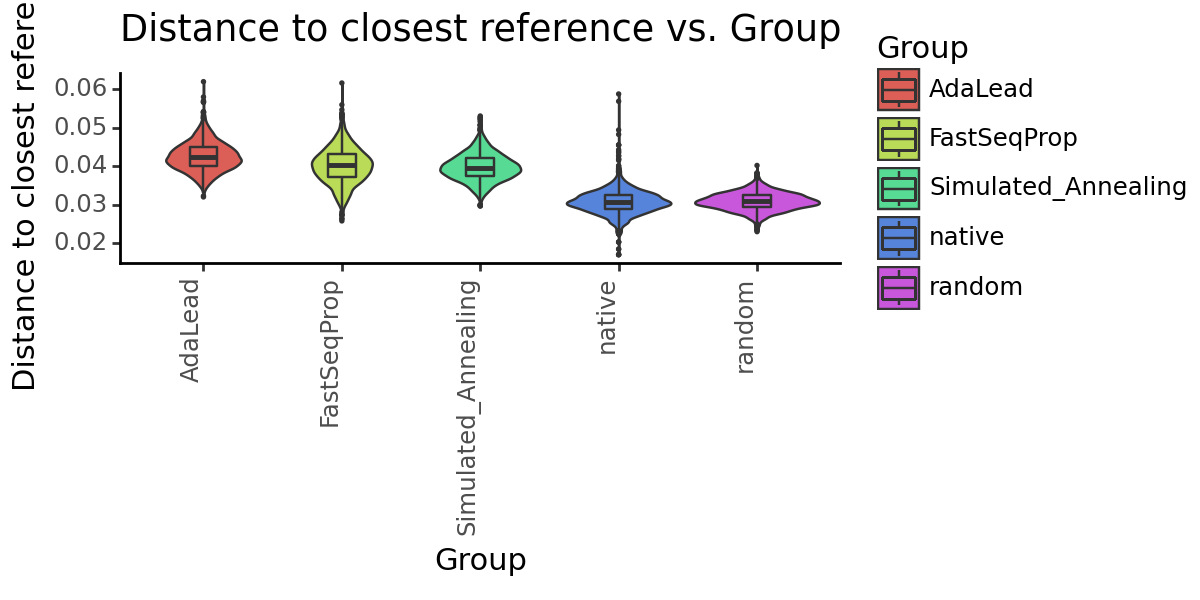

<Figure Size: (600 x 300)>

In [15]:
#Distance to reference
print("p-values for distance to closest reference")
print(emb.uns["ref_dist_test"])

polygraph.visualize.boxplot(emb.obs, value_col='Distance to closest reference') + p9.theme(figure_size=(6, 3))

p-values for KNN diversity
{'Kruskal': 0.0, 'Dunn':                        AdaLead  FastSeqProp  Simulated_Annealing     native  \
AdaLead               1.00e+00    1.56e-186             2.10e-47  6.12e-217   
FastSeqProp          1.56e-186     1.00e+00             1.14e-48   2.07e-02   
Simulated_Annealing   2.10e-47     1.14e-48             1.00e+00   1.38e-64   
native               6.12e-217     2.07e-02             1.38e-64   1.00e+00   
random                0.00e+00     0.00e+00             0.00e+00   0.00e+00   

                     random  
AdaLead                 0.0  
FastSeqProp             0.0  
Simulated_Annealing     0.0  
native                  0.0  
random                  1.0  }


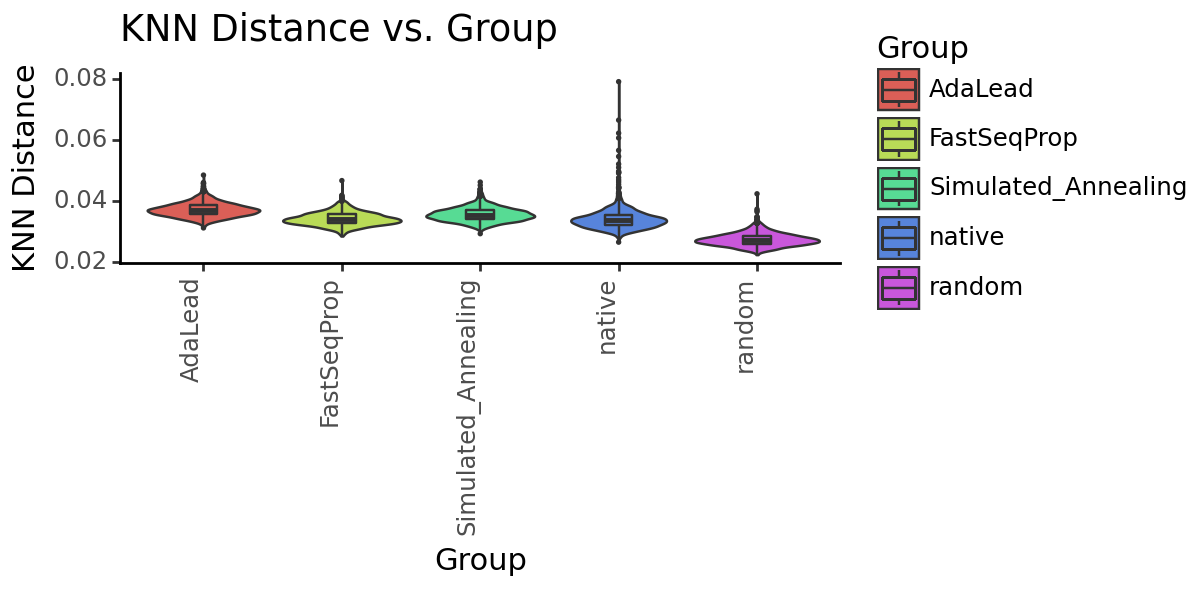

<Figure Size: (600 x 300)>

In [16]:
# KNN distance (diversity metric)
print("p-values for KNN diversity")
print(emb.uns["knn_dist_test"])
polygraph.visualize.boxplot(emb.obs, value_col='KNN Distance') + p9.theme(figure_size=(6, 3))

In [17]:
# Performance of a classifier trained to separate each group from the reference
emb.uns['svm_performance']

,Accuracy,AUROC
Group,,
FastSeqProp,0.99,0.99
Simulated_Annealing,1.00,1.00
AdaLead,1.00,1.00
random,0.98,0.98


## 1.5 Gapped k-mer embedding

In [18]:
%%time
gkm = polygraph.sequence.fastsk(seqs, k=4, m=1)

Length of shortest train sequence: 200
Length of shortest test sequence: 200
CPU times: user 6min 22s, sys: 20.8 s, total: 6min 43s
Wall time: 1min 55s
Dictionary size = 4 (+1 for unknown char).
g = 4, k = 3, 3940000 features
Initializing kernel function


In [28]:
%%time
emb = polygraph.embedding.embedding_analysis(
    gkm, seqs, reference_group='native', max_iter=5000, use_pca=True)

Creating AnnData object
PCA
Fraction of total variance explained by PCA components:  0.9788514746966903
UMAP
Differential feature abundance
1-NN statistics
Within-group KNN diversity
Euclidean distance to nearest reference
Train groupwise classifiers


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinea

CPU times: user 26min 11s, sys: 11min 36s, total: 37min 48s
Wall time: 17min 1s


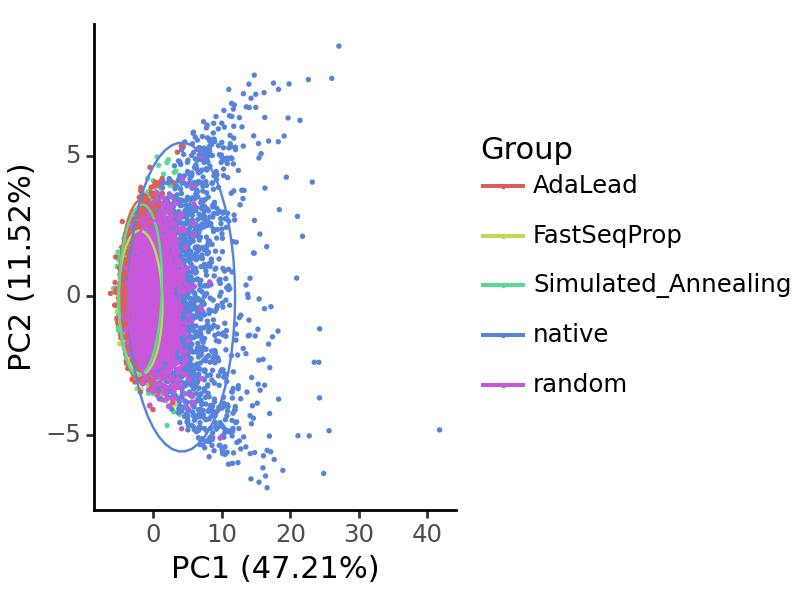

<Figure Size: (400 x 300)>

In [29]:
polygraph.visualize.pca_plot(emb, show_ellipse=True) + p9.theme(figure_size=(4,3))

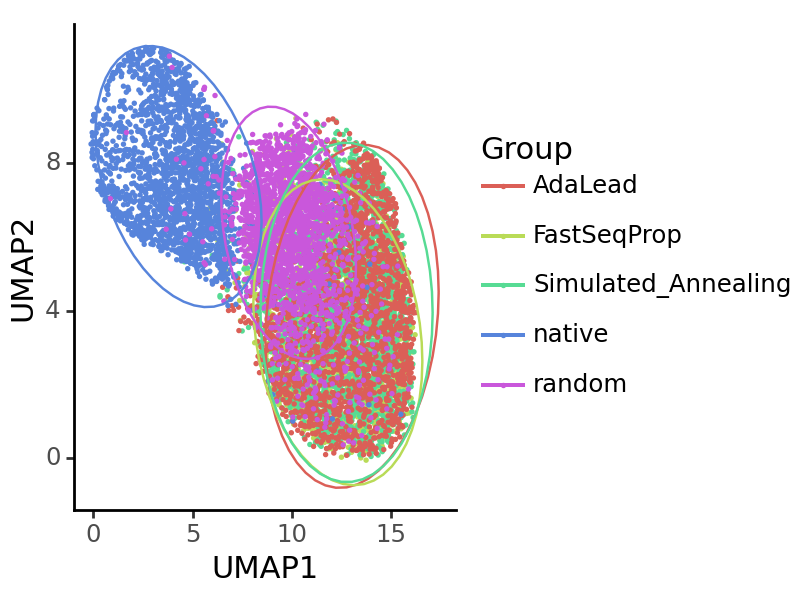

<Figure Size: (400 x 300)>

In [31]:
polygraph.visualize.umap_plot(emb, show_ellipse=True) + p9.theme(figure_size=(4,3))

In [30]:
emb.uns['svm_performance']

,Accuracy,AUROC
Group,,
FastSeqProp,0.99,0.99
Simulated_Annealing,1.00,1.00
AdaLead,1.00,1.00
random,0.99,0.99


# 2. Model based evaluation

### Load model trained on catlas data

In [49]:
!wget https://zenodo.org/records/10214625/files/catlas-enformer-release-model_2.pth

--2024-01-24 20:43:38--  https://zenodo.org/records/10214625/files/catlas-enformer-release-model_2.pth
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.184.103.159, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 288449775 (275M) [application/octet-stream]
Saving to: ‘catlas-enformer-release-model_2.pth’

catlas-enformer-rel 100%[===================>] 275.09M  18.1MB/s    in 17s     

2024-01-24 20:43:56 (16.2 MB/s) - ‘catlas-enformer-release-model_2.pth’ saved [288449775/288449775]



In [19]:
import torch
model = torch.load('catlas-enformer-release-model_2.pth')

## 2.1 Model predictions

In [20]:
preds = polygraph.models.predict(seqs, model, batch_size=512, device=0)
preds.shape

Computing exact kernel...
Computing 4 mismatch profiles using 4 threads...
Thread 2 finished in 1 iterations...
Thread 1 finished in 1 iterations...
Thread 0 finished in 1 iterations...
Thread 3 finished in 1 iterations...


(10000, 203)

## 2.2 Model embeddings

In [21]:
embeddings = polygraph.models.get_embeddings(seqs.Sequence.tolist(), model.to(torch.device(0)), batch_size=512, drop_last_layers=3, swapaxes=True, device=0)
embeddings.shape

(10000, 3072)

In [23]:
%%time
emb = polygraph.embedding.embedding_analysis(embeddings, seqs, reference_group='native', use_pca=True)

Creating AnnData object
PCA
Fraction of total variance explained by PCA components:  0.8693565
UMAP
Differential feature abundance


/usr/local/lib/python3.8/dist-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
/usr/local/lib/python3.8/dist-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
/usr/local/lib/python3.8/dist-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
/usr/local/lib/python3.8/dist-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2


1-NN statistics
Within-group KNN diversity
Euclidean distance to nearest reference
Train groupwise classifiers
CPU times: user 2min 19s, sys: 3min 13s, total: 5min 32s
Wall time: 27.5 s


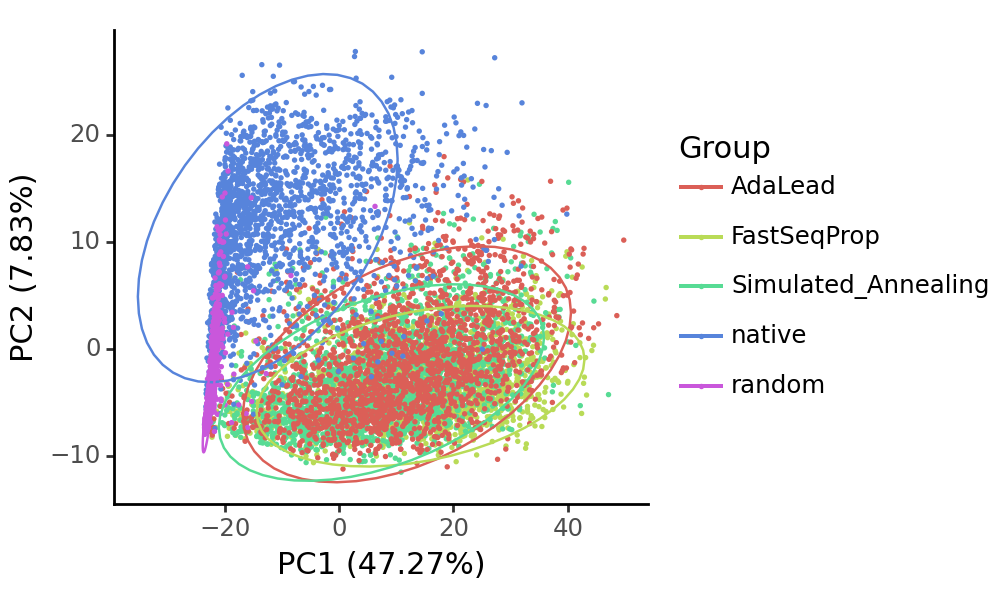

<Figure Size: (500 x 300)>

In [24]:
polygraph.visualize.pca_plot(emb, show_ellipse=True) + p9.theme(figure_size=(5, 3))

                     group_prop  ref_prop  pval  padj
Group                                                
FastSeqProp            1.15e-02      0.97   0.0   0.0
Simulated_Annealing    6.00e-03      0.98   0.0   0.0
AdaLead                4.00e-03      0.98   0.0   0.0
random                 2.45e-02      0.94   0.0   0.0


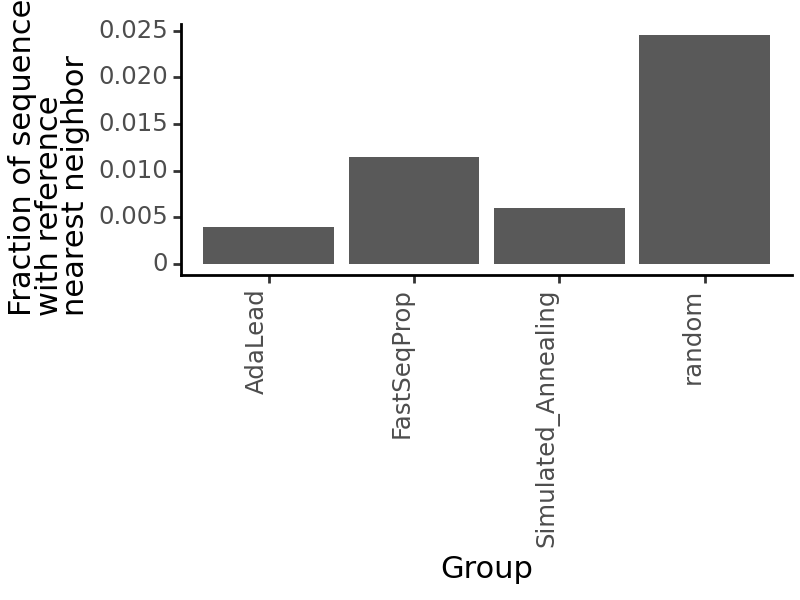

<Figure Size: (400 x 300)>

In [25]:
# 1-NN statistics
print(emb.uns["1NN_ref_prop_test"])

# Plot
polygraph.visualize.one_nn_frac_plot(emb, reference_group="native") + p9.theme(figure_size=(4,3))

{'Kruskal': 0.0, 'Dunn':                        AdaLead  FastSeqProp  Simulated_Annealing     native  \
AdaLead               1.00e+00     5.23e-03             5.61e-34  2.59e-249   
FastSeqProp           5.23e-03     1.00e+00             7.50e-21  3.27e-210   
Simulated_Annealing   5.61e-34     7.50e-21             1.00e+00  3.89e-103   
native               2.59e-249    3.27e-210            3.89e-103   1.00e+00   
random                0.00e+00     0.00e+00             0.00e+00  1.30e-220   

                        random  
AdaLead               0.00e+00  
FastSeqProp           0.00e+00  
Simulated_Annealing   0.00e+00  
native               1.30e-220  
random                1.00e+00  }


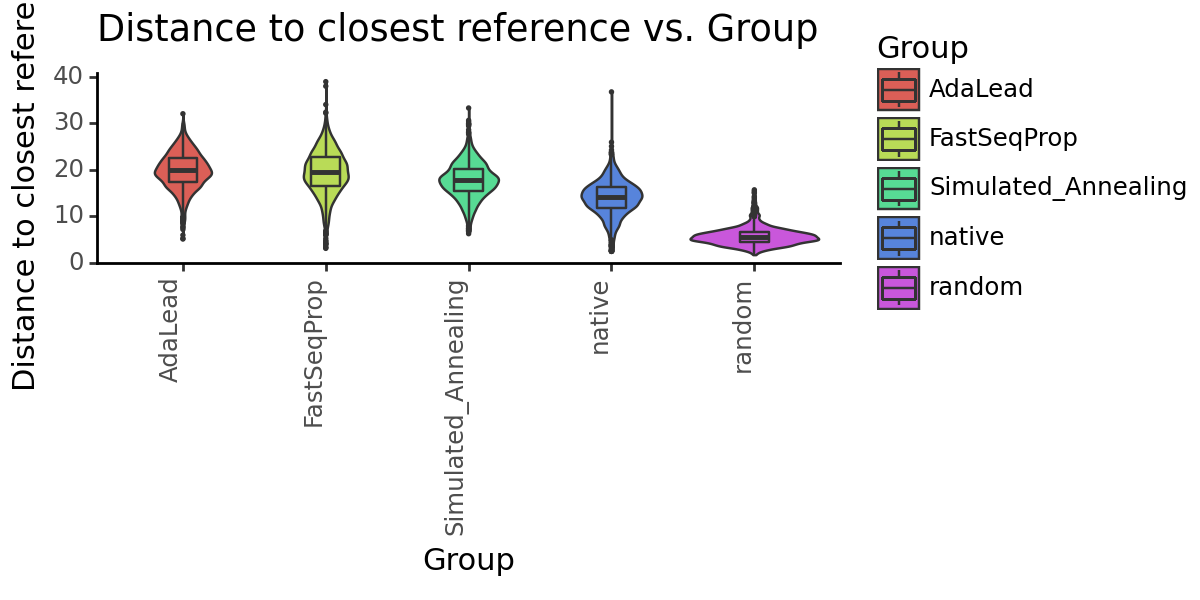

<Figure Size: (600 x 300)>

In [26]:
# Distance to reference
print(emb.uns['ref_dist_test'])
polygraph.visualize.boxplot(emb.obs, value_col='Distance to closest reference') + p9.theme(figure_size=(6, 3))

{'Kruskal': 0.0, 'Dunn':                        AdaLead  FastSeqProp  Simulated_Annealing     native  \
AdaLead               1.00e+00     3.55e-14             4.18e-19  5.82e-126   
FastSeqProp           3.55e-14     1.00e+00             1.72e-01  2.87e-217   
Simulated_Annealing   4.18e-19     1.72e-01             1.00e+00  2.70e-236   
native               5.82e-126    2.87e-217            2.70e-236   1.00e+00   
random                0.00e+00     0.00e+00             0.00e+00   0.00e+00   

                     random  
AdaLead                 0.0  
FastSeqProp             0.0  
Simulated_Annealing     0.0  
native                  0.0  
random                  1.0  }


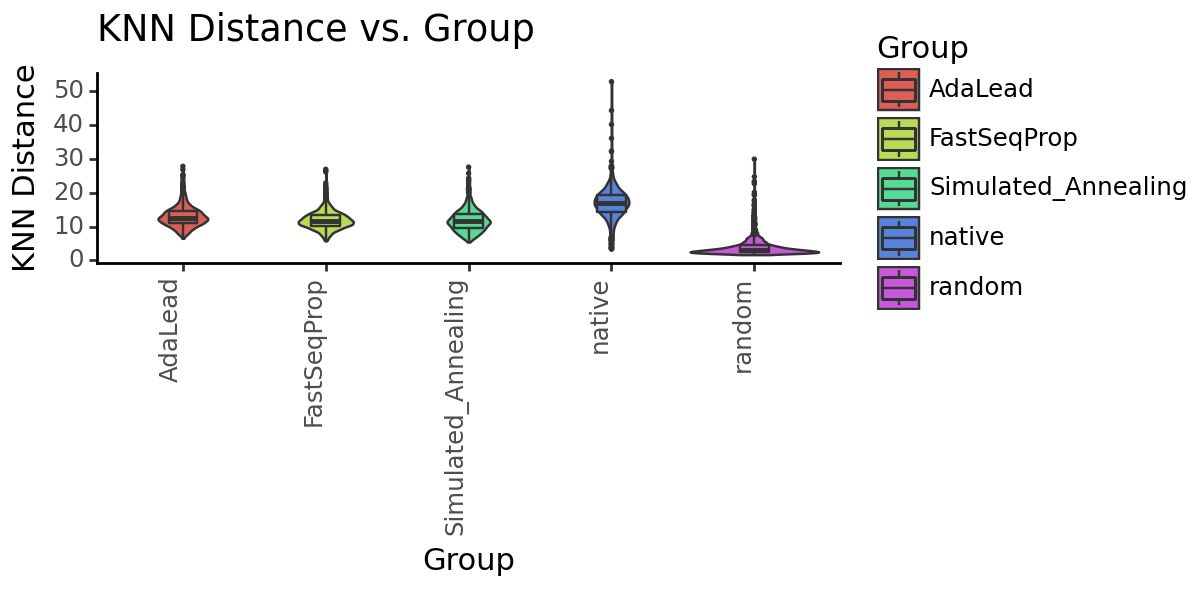

<Figure Size: (600 x 300)>

In [27]:
# KNN distance (diversity metric)
print(emb.uns['knn_dist_test'])
polygraph.visualize.boxplot(emb.obs, value_col='KNN Distance') + p9.theme(figure_size=(6, 3))

In [28]:
# Classifier performance
emb.uns['svm_performance']

,Accuracy,AUROC
Group,,
FastSeqProp,1.0,1.0
Simulated_Annealing,1.0,1.0
AdaLead,1.0,1.0
random,1.0,1.0


# 3. Evaluate Motif content

## 3.1 Scan sequences with JASPAR motifs

In [4]:
meme_file = polygraph.input.download_jaspar("vertebrates")
meme_file

--2024-01-29 01:38:07--  https://jaspar.elixir.no/download/data/2024/CORE/JASPAR2024_CORE_vertebrates_non-redundant_pfms_meme.txt
Resolving jaspar.elixir.no (jaspar.elixir.no)... 158.39.48.179, 2001:700:2:8200::26fc
Connecting to jaspar.elixir.no (jaspar.elixir.no)|158.39.48.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 469100 (458K) [text/plain]
Saving to: ‘/usr/local/lib/python3.8/dist-packages/polygraph/resources/jaspar/JASPAR2024_CORE_vertebrates_non-redundant_pfms_meme.txt’

     0K .......... .......... .......... .......... .......... 10%  150K 3s
    50K .......... .......... .......... .......... .......... 21%  302K 2s
   100K .......... .......... .......... .......... .......... 32%  302K 1s
   150K .......... .......... .......... .......... .......... 43% 99.5M 1s
   200K .......... .......... .......... .......... .......... 54%  302K 1s
   250K .......... .......... .......... .......... .......... 65%  260M 0s
   300K .......... ........

'/usr/local/lib/python3.8/dist-packages/polygraph/resources/jaspar/JASPAR2022_CORE_vertebrates_non-redundant_pfms_meme.txt'

In [3]:
%%time 
sites = polygraph.motifs.scan(seqs, '/usr/local/lib/python3.8/dist-packages/polygraph/resources/jaspar/JASPAR2024_CORE_vertebrates_non-redundant_pfms_meme.txt')

Read 879 motifs from file.
CPU times: user 3min 27s, sys: 624 ms, total: 3min 28s
Wall time: 3min 28s


## 3.2 Filter by TF expression in whole blood

In [4]:
## Subset motifs using tissue-specific expression from GTEX
gtex = polygraph.input.load_gtex_tpm()

File already exists at /usr/local/lib/python3.8/dist-packages/polygraph/resources/gtex/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.gct.gz


In [5]:
gtex.head()

,Name,Description,Adipose - Subcutaneous,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Bladder,Brain - Amygdala,...,Skin - Not Sun Exposed (Suprapubic),Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole Blood
0,ENSG00000223972.5,DDX11L1,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.17,0.00,0.00,0.00,0.00
1,ENSG00000227232.5,WASH7P,4.06,3.37,2.69,4.05,3.9,3.64,5.16,1.44,...,5.93,6.13,4.19,5.93,3.06,4.70,6.27,7.19,5.75,2.65
2,ENSG00000278267.1,MIR6859-1,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,ENSG00000243485.5,MIR1302-2HG,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.05,0.00,0.00,0.00,0.00
4,ENSG00000237613.2,FAM138A,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [6]:
all_motifs = set(sites.MotifID.str.upper())

In [7]:
blood_motifs = all_motifs.intersection(gtex.loc[gtex['Whole Blood'] > 0, 'Description'])
len(blood_motifs)

557

In [8]:
sites = sites[sites.MotifID.isin(blood_motifs)]

## 3.1 Motif count embedding

In [9]:
counts = polygraph.motifs.motif_frequencies(sites, seqs=seqs, normalize=True)
counts.iloc[:5, :5]

,ARNT2,ATF2,ATF3,ATF4,ATF6
SeqID,,,,,
seq_0,5.00e-03,0.00e+00,0.00e+00,0.0,0.00e+00
seq_1,0.00e+00,5.00e-03,0.00e+00,0.0,0.00e+00
seq_2,0.00e+00,0.00e+00,0.00e+00,0.0,5.00e-03
seq_3,1.00e-02,0.00e+00,0.00e+00,0.0,0.00e+00
seq_4,0.00e+00,0.00e+00,5.00e-03,0.0,0.00e+00


In [10]:
%%time
emb = polygraph.embedding.embedding_analysis(counts, seqs, reference_group='native', use_pca=True)

Creating AnnData object
PCA
Fraction of total variance explained by PCA components:  0.6318056188994973
UMAP


2024-01-31 02:08:04.806743: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Differential feature abundance
1-NN statistics
Within-group KNN diversity
Euclidean distance to nearest reference
Train groupwise classifiers
CPU times: user 2min 39s, sys: 2min 39s, total: 5min 19s
Wall time: 41.9 s


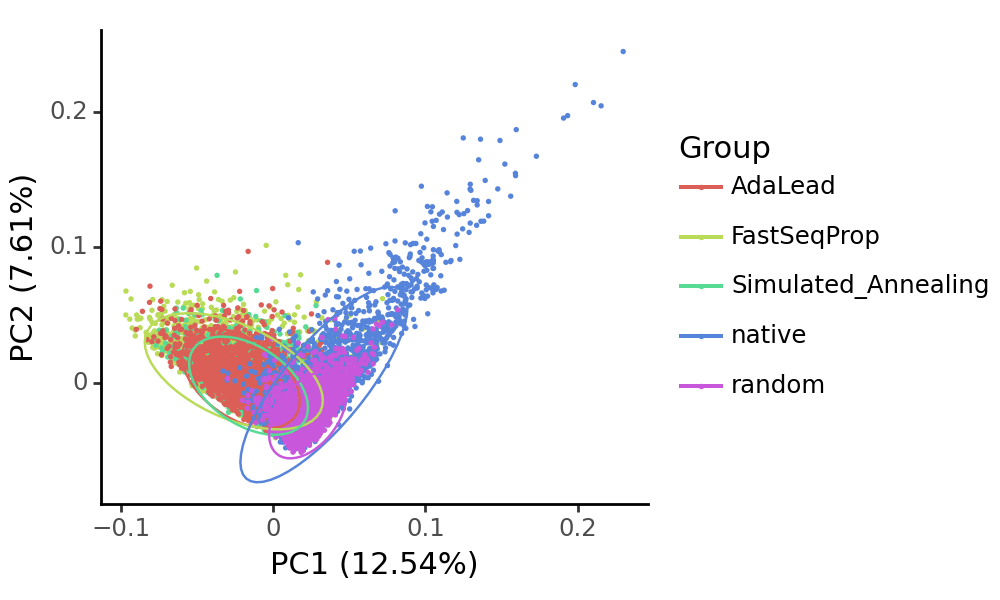

<Figure Size: (500 x 300)>

In [12]:
polygraph.visualize.pca_plot(emb, show_ellipse=True) + p9.theme(figure_size=(5, 3))

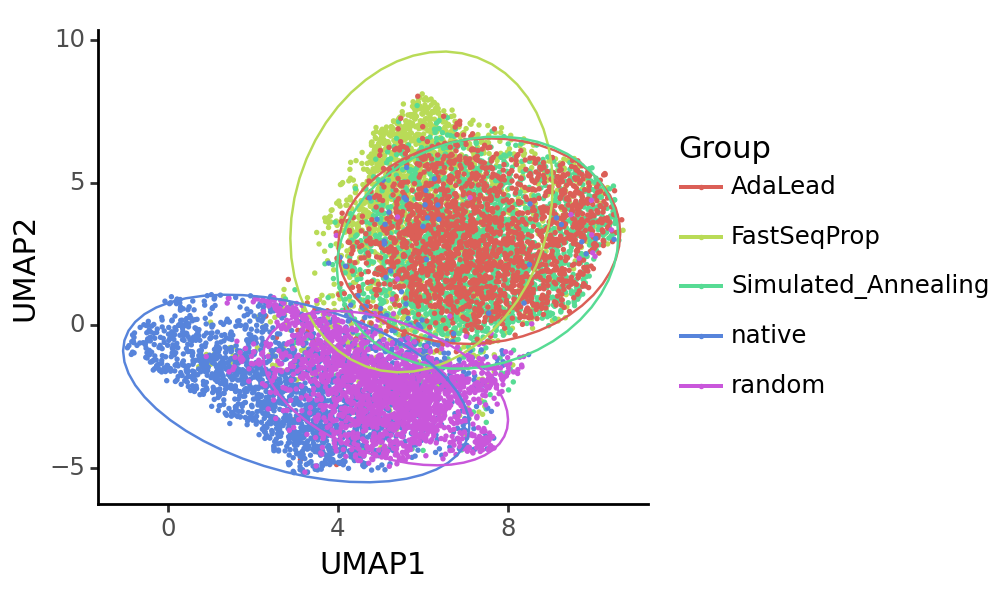

<Figure Size: (500 x 300)>

In [13]:
polygraph.visualize.umap_plot(emb, show_ellipse=True) + p9.theme(figure_size=(5, 3))

In [14]:
# Differential motif abundance

print("Number of differential motifs compared to reference")
print(emb.uns["DE_test"][emb.uns["DE_test"].padj < .05].Group.value_counts())

print("")

print("Top Differential motifs")
print(emb.uns["DE_test"][emb.uns["DE_test"].padj < .05].sort_values('padj').head())

Number of differential motifs compared to reference
AdaLead                398
Simulated_Annealing    384
FastSeqProp            366
random                 362
Name: Group, dtype: int64

Top Differential motifs
                   Group  value  score  padj  log2FC
0                AdaLead  GATA2  47.83   0.0    1.72
476          FastSeqProp  GATA6  41.77   0.0    1.59
477          FastSeqProp  GATA4  38.64   0.0    1.42
478          FastSeqProp   TBX3  37.91   0.0    2.27
948  Simulated_Annealing  GATA2  44.32   0.0    1.52


p-values for proportion of sequences with native nearest neighbor
                     group_prop  ref_prop  pval  padj
Group                                                
FastSeqProp                0.07      0.95   0.0   0.0
Simulated_Annealing        0.03      0.96   0.0   0.0
AdaLead                    0.02      0.98   0.0   0.0
random                     0.10      0.78   0.0   0.0


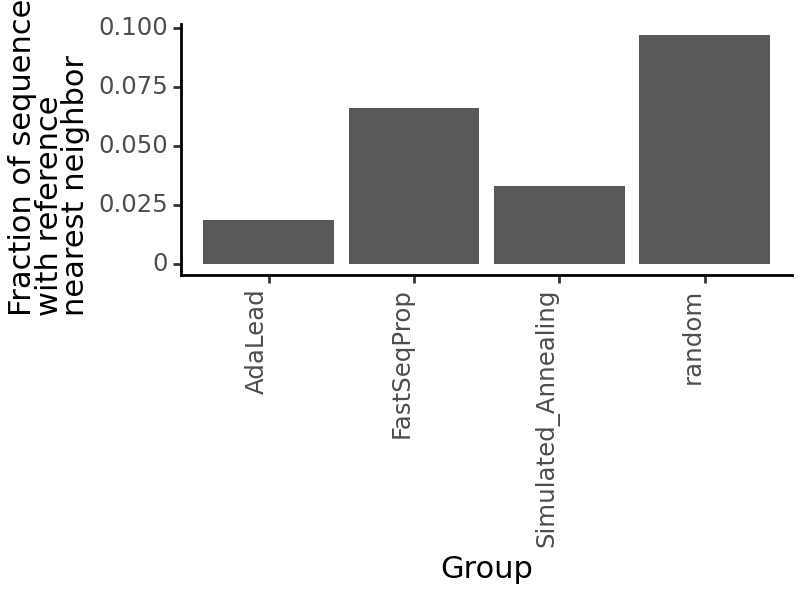

<Figure Size: (400 x 300)>

In [15]:
# 1-NN statistics
print("p-values for proportion of sequences with native nearest neighbor")
print(emb.uns["1NN_ref_prop_test"])

# Plot
polygraph.visualize.one_nn_frac_plot(emb, reference_group="native") + p9.theme(figure_size=(4,3))

p-values for distance to closest reference
{'Kruskal': 0.0, 'Dunn':                        AdaLead  FastSeqProp  Simulated_Annealing     native  \
AdaLead               1.00e+00     5.06e-09             1.04e-12  6.70e-238   
FastSeqProp           5.06e-09     1.00e+00             1.96e-01  1.90e-161   
Simulated_Annealing   1.04e-12     1.96e-01             1.00e+00  1.22e-146   
native               6.70e-238    1.90e-161            1.22e-146   1.00e+00   
random                0.00e+00     0.00e+00             0.00e+00   9.48e-37   

                       random  
AdaLead              0.00e+00  
FastSeqProp          0.00e+00  
Simulated_Annealing  0.00e+00  
native               9.48e-37  
random               1.00e+00  }


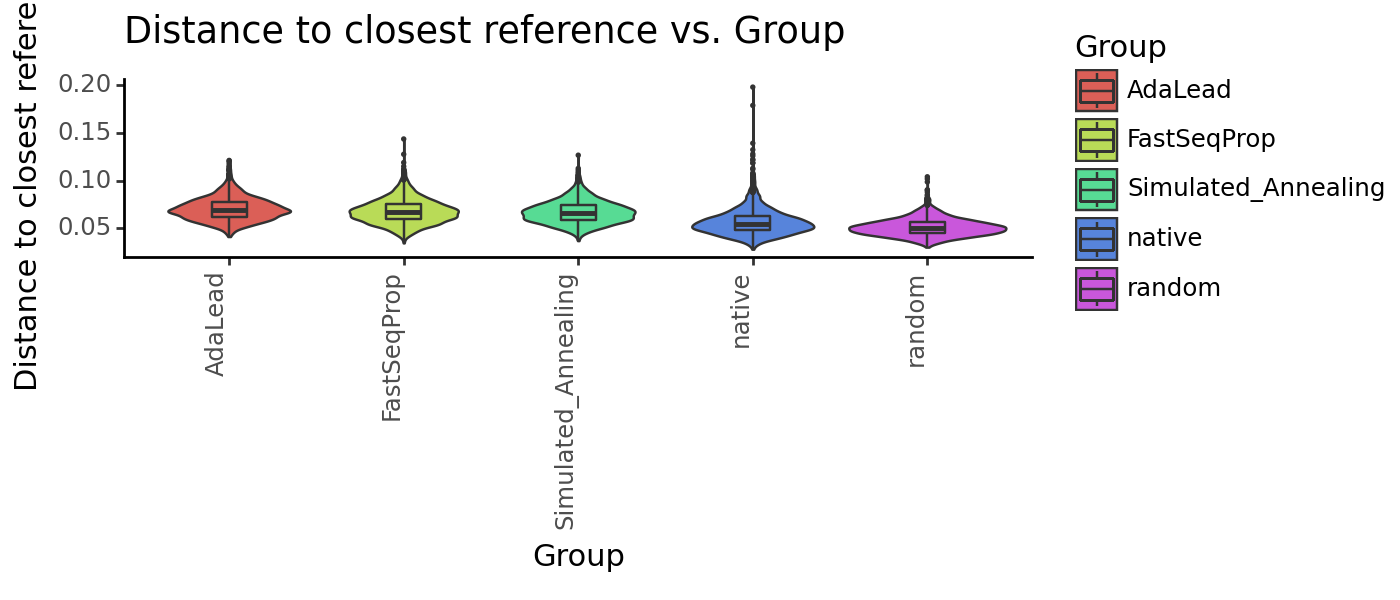

<Figure Size: (700 x 300)>

In [16]:
#Distance to reference
print("p-values for distance to closest reference")
print(emb.uns["ref_dist_test"])

polygraph.visualize.boxplot(emb.obs, value_col='Distance to closest reference') + p9.theme(figure_size=(7, 3))

p-values for KNN diversity
{'Kruskal': 0.0, 'Dunn':                        AdaLead  FastSeqProp  Simulated_Annealing     native  \
AdaLead               1.00e+00     4.66e-20             8.61e-07   7.61e-02   
FastSeqProp           4.66e-20     1.00e+00             2.25e-05   7.61e-28   
Simulated_Annealing   8.61e-07     2.25e-05             1.00e+00   2.29e-11   
native                7.61e-02     7.61e-28             2.29e-11   1.00e+00   
random               2.49e-249    1.19e-132            5.66e-182  9.42e-276   

                        random  
AdaLead              2.49e-249  
FastSeqProp          1.19e-132  
Simulated_Annealing  5.66e-182  
native               9.42e-276  
random                1.00e+00  }


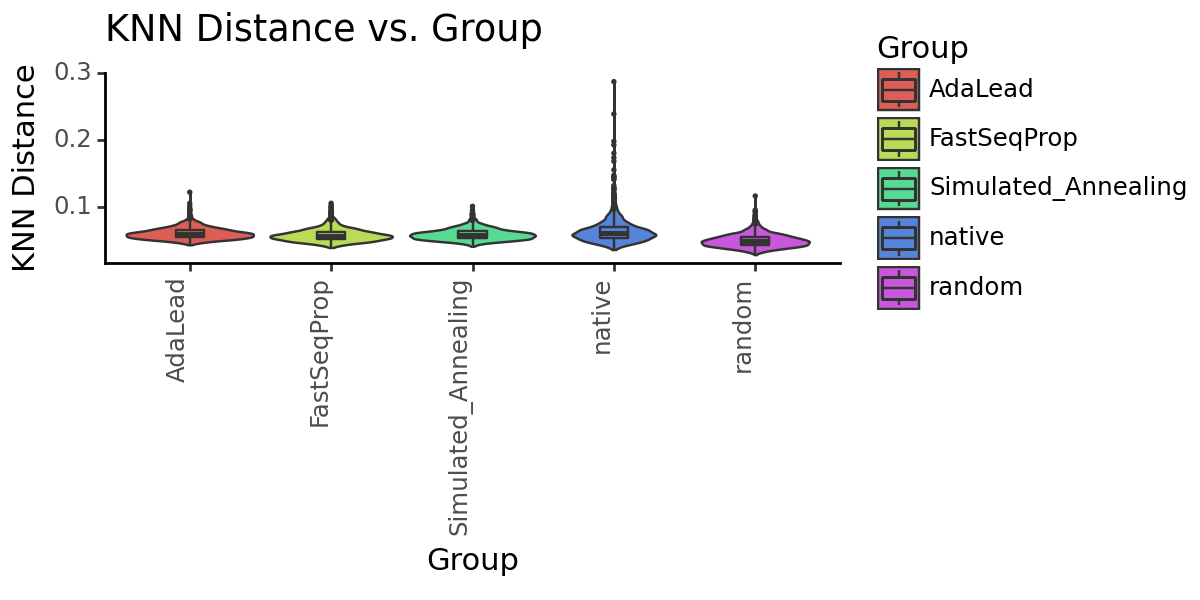

<Figure Size: (600 x 300)>

In [17]:
# KNN distance (diversity metric)
print("p-values for KNN diversity")
print(emb.uns["knn_dist_test"])
polygraph.visualize.boxplot(emb.obs, value_col='KNN Distance') + p9.theme(figure_size=(6, 3))

In [18]:
# Classifier performance
emb.uns['svm_performance']

,Accuracy,AUROC
Group,,
FastSeqProp,0.97,0.97
Simulated_Annealing,0.99,0.99
AdaLead,0.99,0.99
random,0.95,0.95


## 3.2 Motif combinations

We will identify co-occurring combinations of motifs using the count matrix. This can take a long time, so for speed we use only the first 50 motifs.

In [19]:
%%time
motif_combinations = polygraph.motifs.motif_combinations(
    counts.iloc[:, :50], seqs, reference_group='native', min_group_freq=400)

Listing motif combinations
Making count matrix
Filtering
Selected 1300 combinations
Significance testing
CPU times: user 19.8 s, sys: 51.3 ms, total: 19.9 s
Wall time: 19.9 s


In [20]:
motif_combinations.sort_values('padj').head()

,Group,group_prop,ref_prop,pval,padj,combination
26,AdaLead,0.58,0.04,0.0,0.0,"(E2F1, E2F7)"
30,AdaLead,0.58,0.03,0.0,0.0,"(E2F2, E2F7)"
29,Simulated_Annealing,0.62,0.03,0.0,0.0,"(E2F2, E2F7)"
25,Simulated_Annealing,0.63,0.04,0.0,0.0,"(E2F1, E2F7)"
22,AdaLead,0.62,0.04,0.0,0.0,"(E2F2, E2F8)"


In [21]:
# Are there any significant motif combinations where neither individual motif
# is significant?
sig_motifs = emb.uns["DE_test"][emb.uns["DE_test"].padj < .05].value.tolist()
sig_combs = motif_combinations[motif_combinations['padj'] < .05]
sig_combs = sig_combs[sig_combs.combination.apply(lambda c: (c[0] not in sig_motifs) and (c[1] not in sig_motifs))]

In [22]:
sig_combs

,Group,group_prop,ref_prop,pval,padj,combination


## 3.3 Motif positions

In [23]:
# Select the TF motif most enriched in synthetic sequences
emb.uns['DE_test'].sort_values('padj').head()

,Group,value,score,padj,log2FC
0,AdaLead,GATA2,47.83,0.0,1.72
476,FastSeqProp,GATA6,41.77,0.0,1.59
477,FastSeqProp,GATA4,38.64,0.0,1.42
478,FastSeqProp,TBX3,37.91,0.0,2.27
948,Simulated_Annealing,GATA2,44.32,0.0,1.52


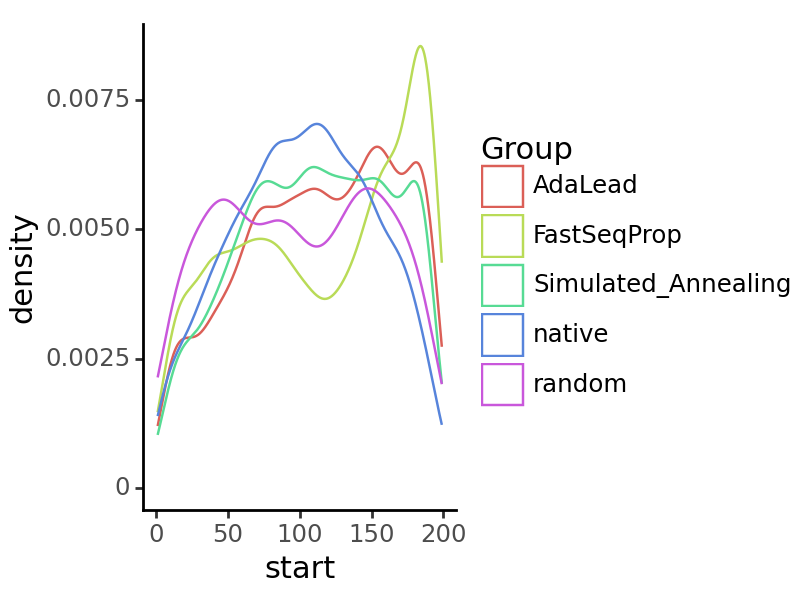

<Figure Size: (400 x 300)>

In [24]:
polygraph.visualize.densityplot(sites[sites.MotifID=='GATA2'], value_col='start') + p9.theme(figure_size=(4, 3))

In [25]:
polygraph.stats.kruskal_dunn(sites[sites.MotifID=='GATA2'], val_col='start')

{'Kruskal': 1.0023563364372272e-27,
 'Dunn':                       AdaLead  FastSeqProp  Simulated_Annealing    native  \
 AdaLead              1.00e+00     3.10e-02             1.04e-03  1.21e-15   
 FastSeqProp          3.10e-02     1.00e+00             8.46e-08  3.34e-21   
 Simulated_Annealing  1.04e-03     8.46e-08             1.00e+00  2.52e-08   
 native               1.21e-15     3.34e-21             2.52e-08  1.00e+00   
 random               2.82e-08     1.42e-10             3.98e-05  5.59e-01   
 
                        random  
 AdaLead              2.82e-08  
 FastSeqProp          1.42e-10  
 Simulated_Annealing  3.98e-05  
 native               5.59e-01  
 random               1.00e+00  }

## 3.4 NMF

In [11]:
%%time
W, H, p = polygraph.motifs.nmf(counts, seqs, reference_group='native', n_components=10)

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.


CPU times: user 1min 26s, sys: 1min 16s, total: 2min 43s
Wall time: 2.64 s


In [12]:
p.sort_values('padj', ascending=False).head()

,group,pval,padj,factor
3,random,3.03e-02,3.03e-02,factor_0
3,random,3.61e-05,3.71e-05,factor_4
3,random,1.87e-06,1.97e-06,factor_1
2,AdaLead,2.87e-07,3.10e-07,factor_6
1,Simulated_Annealing,2.59e-21,2.88e-21,factor_6


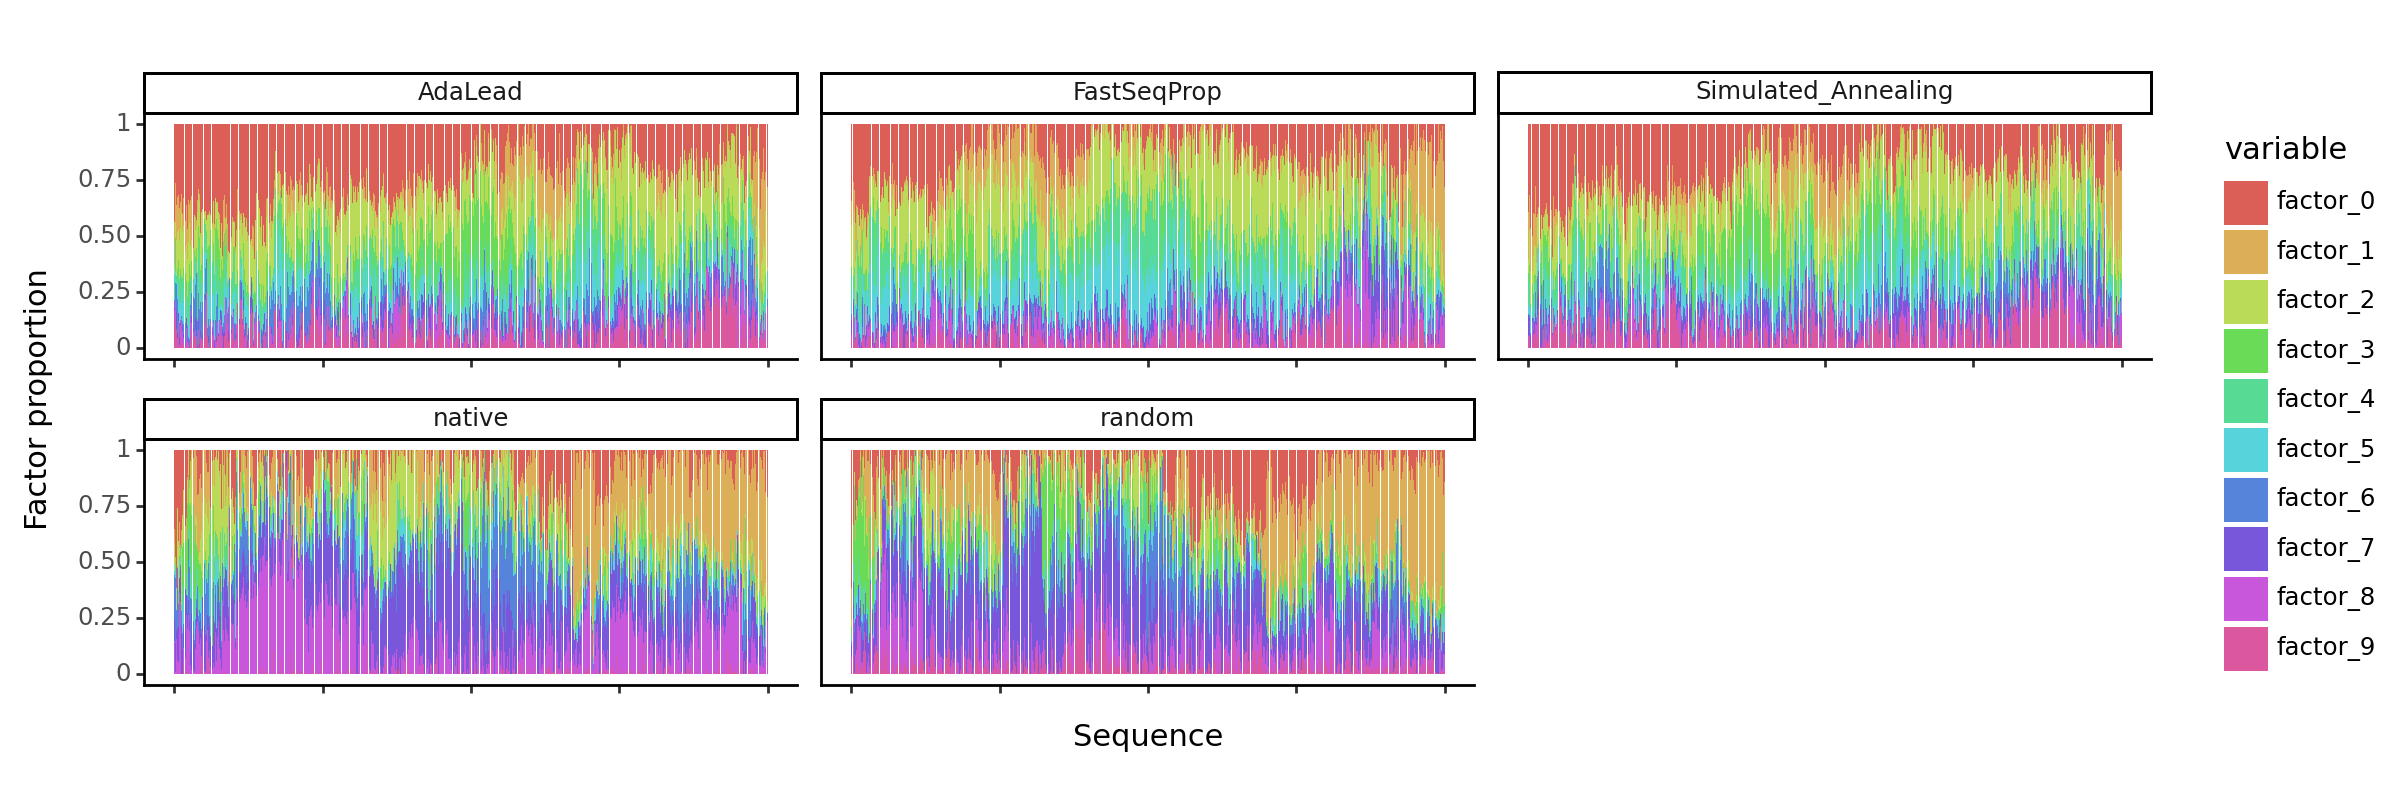

<Figure Size: (1200 x 400)>

In [13]:
polygraph.visualize.plot_seqs_nmf(W) + p9.theme(figure_size=(12, 4))

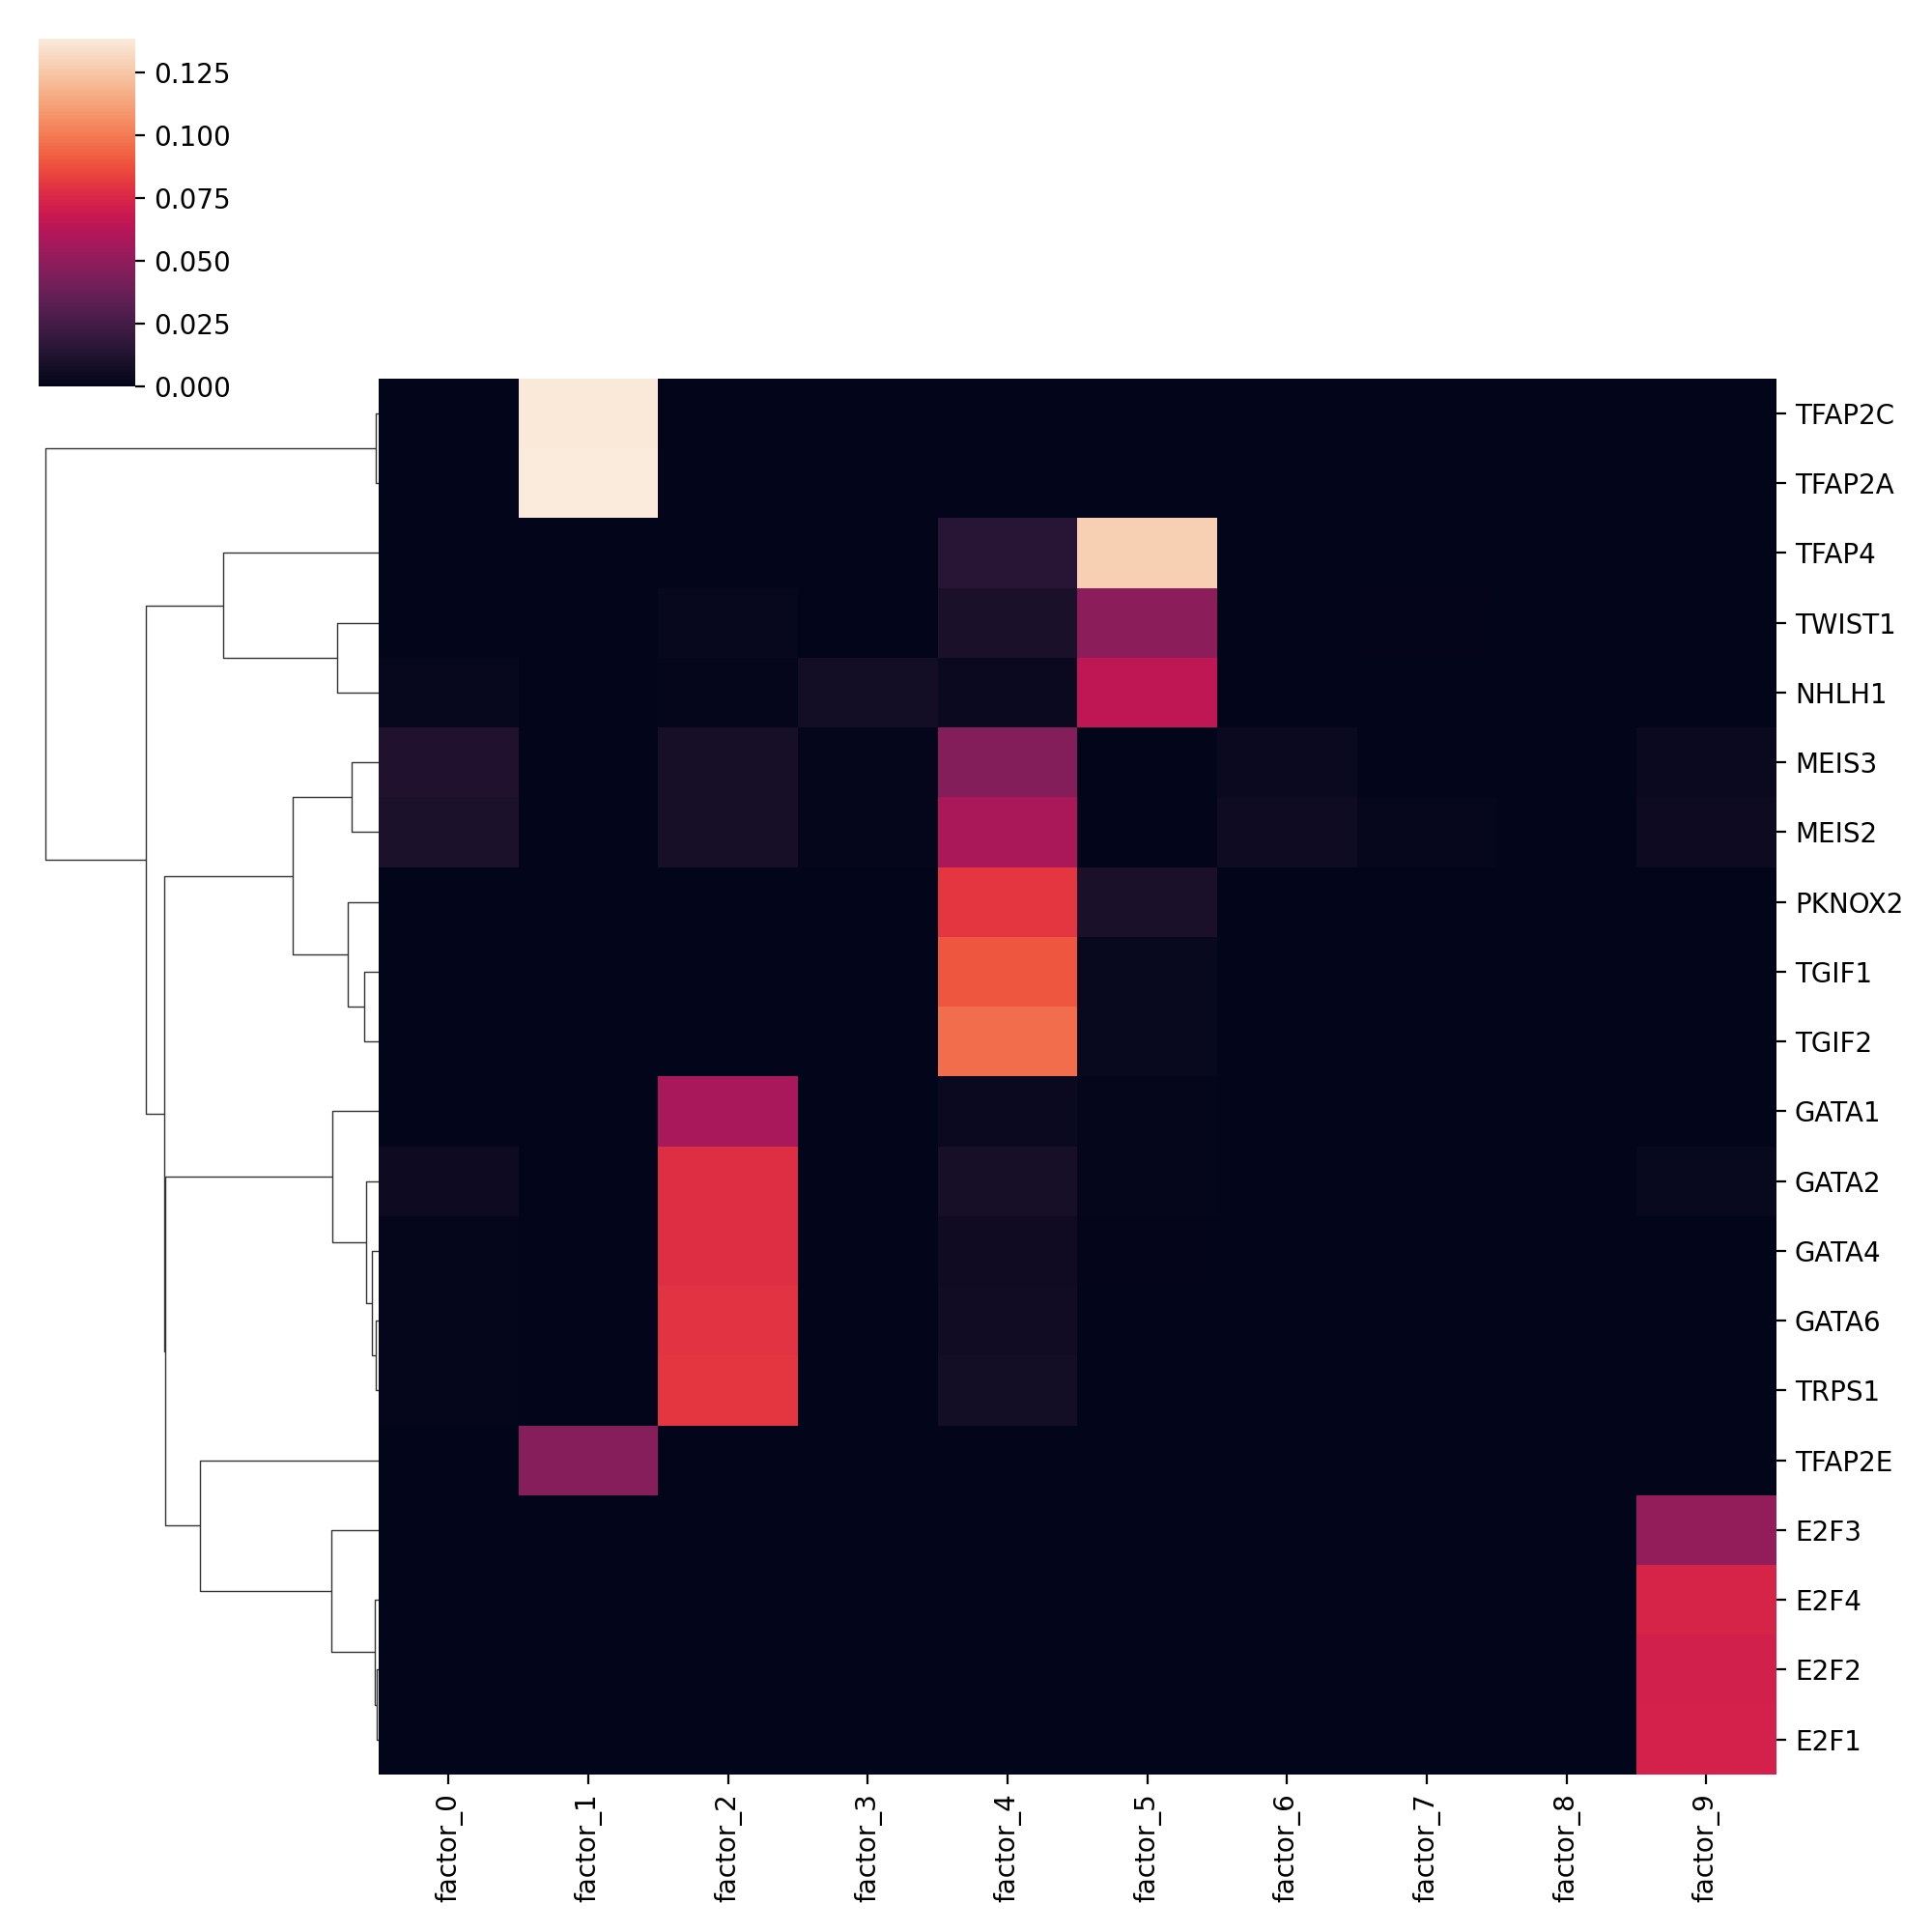

In [16]:
polygraph.visualize.plot_factors_nmf(H, n_features=20)

# 4. Language model likelihood calculation

In [17]:
# Substitute '/hyena-dna' with the path to your cloned hyena-dna repository
# See https://github.com/HazyResearch/hyena-dna for instructions to clone and install hyenadna
model = polygraph.likelihood.load_hyenadna(hyena_path='/hyena-dna')

In [ ]:
log_likelihood = polygraph.likelihood.compute_likelihood(
    seqs, model, num_workers=8, device=0)
seqs['log_likelihood'] = log_likelihood

In [ ]:
polygraph.visualize.boxplot(seqs, group_col="Group", value_col="log_likelihood") + p9.theme(figure_size=(8, 3))